In [1]:
#|default_exp init

# Initialization

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from little_ai.datasets import *
from little_ai.conv import *
from little_ai.learner import *
from little_ai.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
ds = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = ds.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [5]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

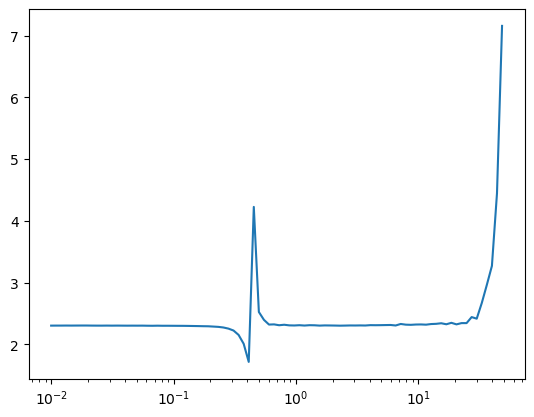

In [6]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.251,2.048,0,train
0.633,0.971,0,eval


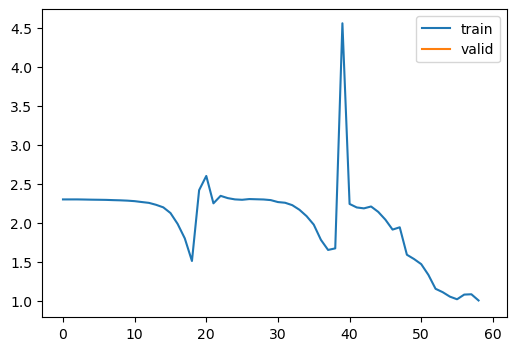

In [8]:
learn.fit(1)

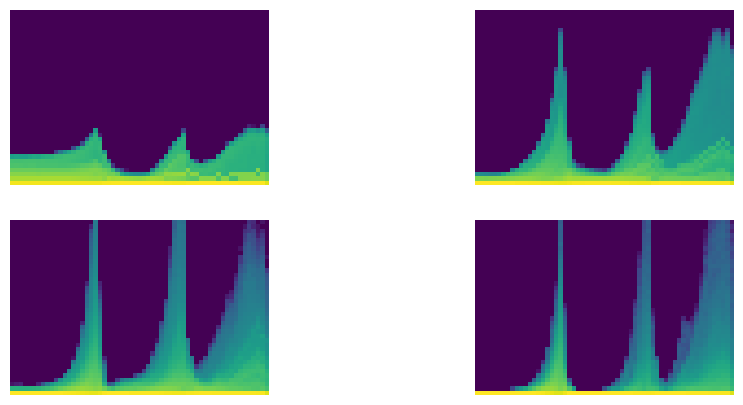

In [9]:
astats.color_dim()

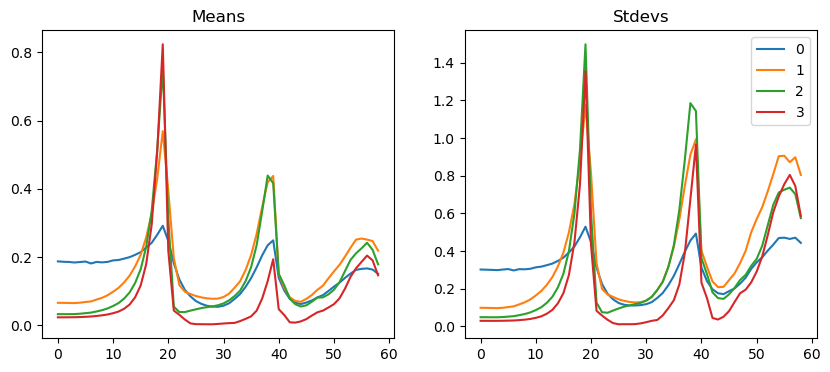

In [10]:
astats.plot_stats()

# Glorot/Xavier init
[paper](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [11]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[:5, :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [12]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.01)
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [13]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.1) #1/sqrt(n)
x[:5, :5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

# Kaiming/He init
[paper](https://arxiv.org/abs/1502.01852)

## Background

In [14]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [15]:
from math import sqrt

In [16]:
w1 = torch.randn(100, 50)/sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50, 1)/sqrt(50)
b2 = torch.zeros(50)

In [17]:
def lin(x, w, b): return x@w + b

In [18]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.00), tensor(1.01))

In [19]:
def relu(x): return x.clamp_min(0.)

In [20]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.59))

In [21]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

The Glorot init doesn't work well with relu function. As suggested in the above paper, we should use the scaling factor $\sqrt{2/n_{in}}$, where $n_{in}$ is the number of inputs

In [22]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 1.33, 0.56, 0.00, 0.76],
        [0.00, 0.77, 0.37, 0.00, 0.40],
        [0.00, 0.80, 0.24, 0.00, 0.45],
        [0.00, 0.67, 0.22, 0.00, 0.49],
        [0.00, 0.41, 0.17, 0.00, 0.27]])

## Applying an init function

In [23]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [24]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [25]:
model.apply(init_weights);

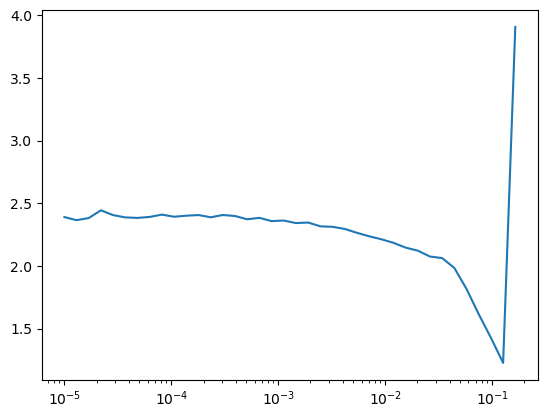

In [26]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [27]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.278,2.063,0,train
0.586,1.124,0,eval
0.592,1.165,1,train
0.760,0.617,1,eval
0.800,0.540,2,train
0.805,0.530,2,eval


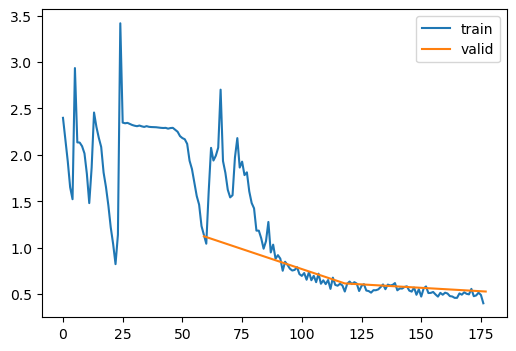

In [28]:
learn.fit(3)

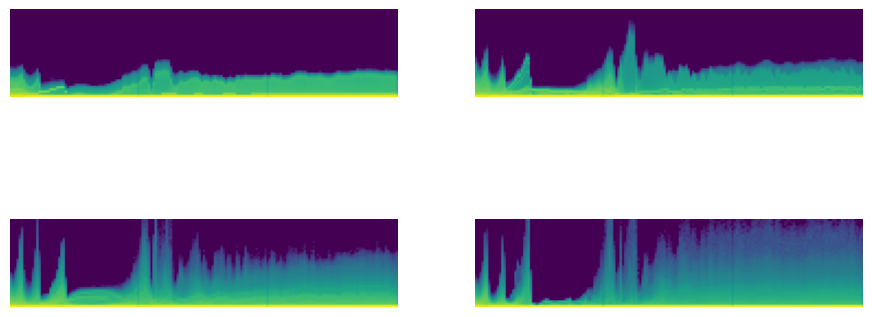

In [29]:
astats.color_dim()

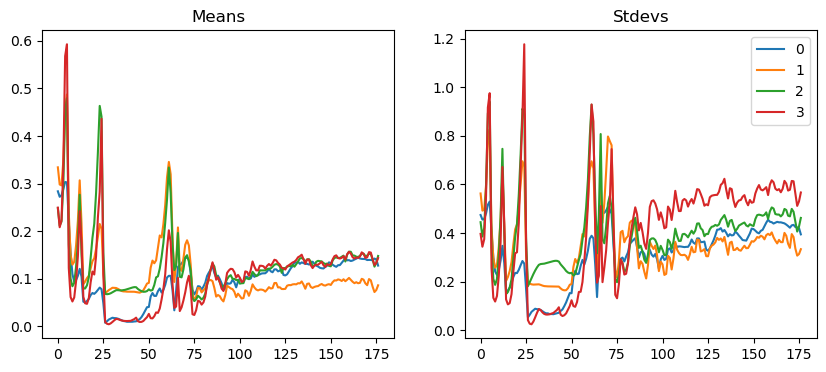

In [30]:
astats.plot_stats()

# Input Normalization

In [31]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [32]:
#|export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_valid=False): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [33]:
def _norm(b): return (b[0]-xmean)/xstd, b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.337,2.149,0,train
0.332,1.708,0,eval
0.695,0.867,1,train
0.113,2.782,1,eval
0.803,0.534,2,train
0.100,3.961,2,eval


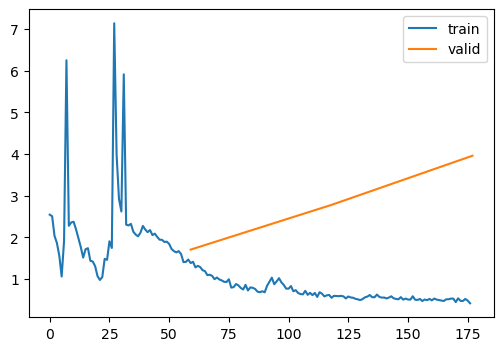

In [34]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

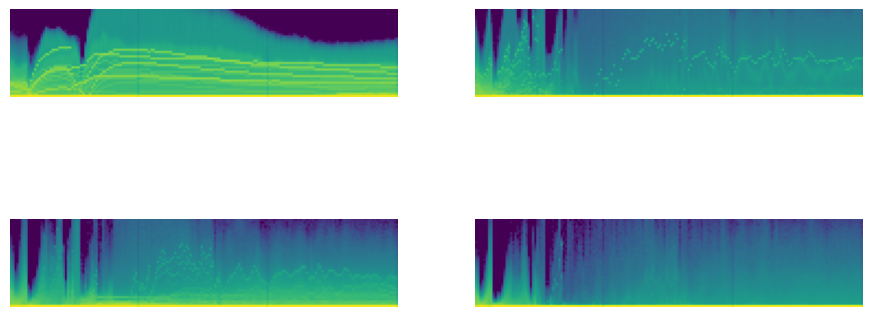

In [35]:
astats.color_dim()

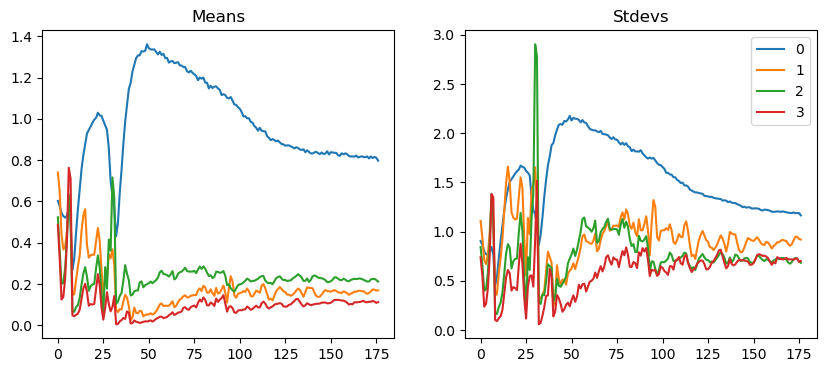

In [36]:
astats.plot_stats()

In [37]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean)/xstd for o in b[xl]]
tds = ds.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))

In [38]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.00))

# General ReLU

In [39]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [40]:
#|export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

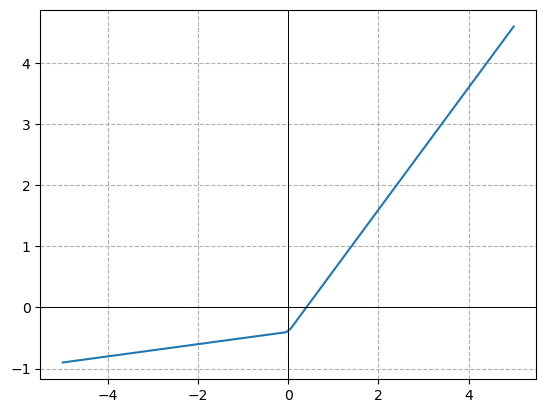

In [41]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [42]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [43]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [44]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [45]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [46]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.734,0.792,0,train
0.842,0.440,0,eval
0.865,0.369,1,train
0.863,0.374,1,eval
0.882,0.326,2,train
0.864,0.371,2,eval


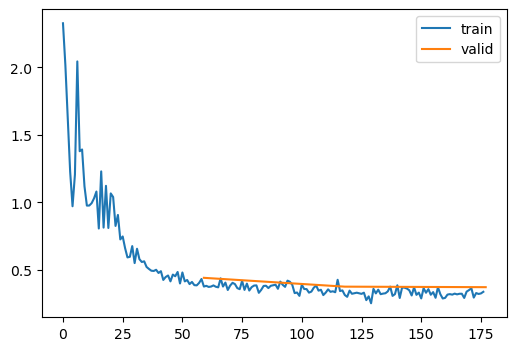

In [47]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

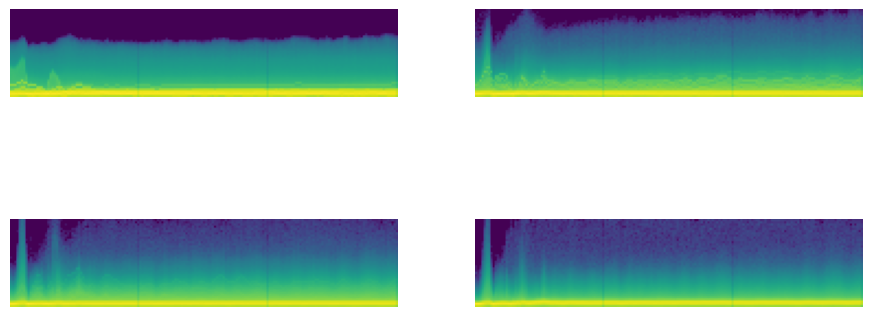

In [48]:
astats.color_dim()

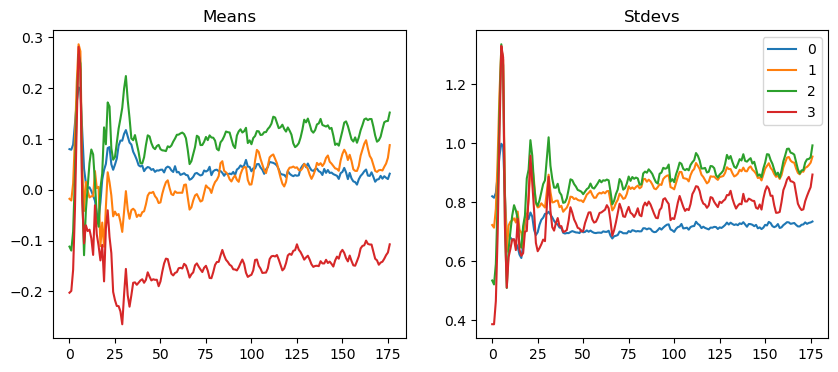

In [49]:
astats.plot_stats()

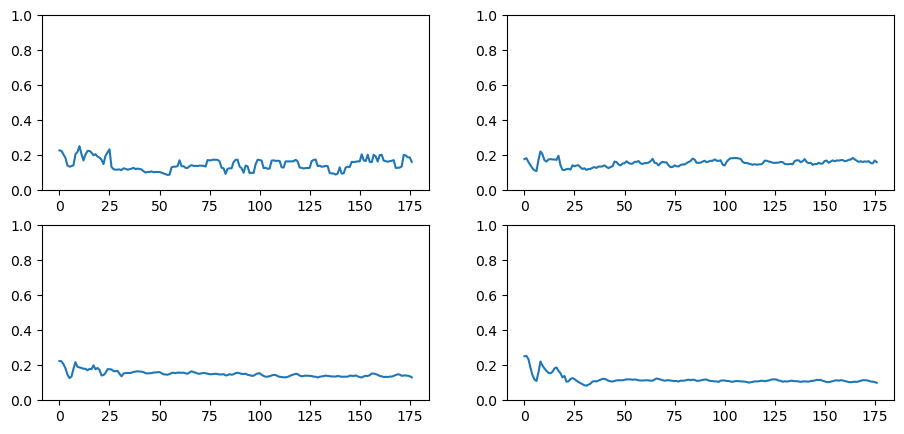

In [50]:
astats.dead_chart()

# LSUV
[All you need is a good init](https://arxiv.org/pdf/1511.06422.pdf) introduces Layer-wise Sequential Unit-Variance (LSUV)

In [51]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [52]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [53]:
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [54]:
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.769,0.658,0,train
0.832,0.460,0,eval
0.861,0.379,1,train
0.854,0.400,1,eval
0.877,0.335,2,train
0.860,0.381,2,eval


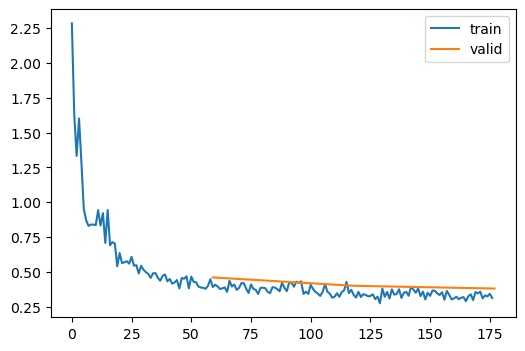

In [55]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

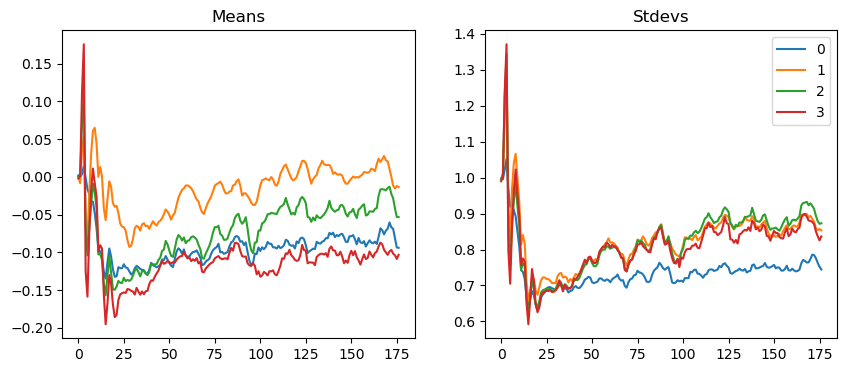

In [56]:
astats.plot_stats()

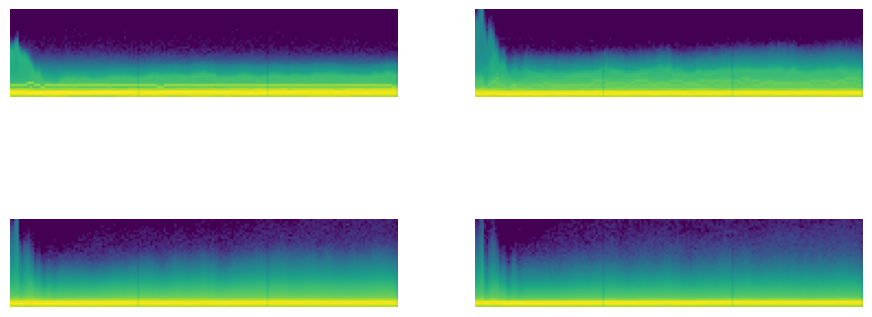

In [57]:
astats.color_dim()

# Batch Normalization
[paper](https://arxiv.org/abs/1502.03167)

Problem:
>Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Proposal:
>Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

## LayerNorm

[Layer Normalization](https://arxiv.org/abs/1607.06450) is a simpler technique than Batch Normalization

In [58]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [59]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [60]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [61]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## BatchNorm

In [62]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.791,0.578,0,train
0.826,0.501,0,eval
0.868,0.356,1,train
0.861,0.389,1,eval
0.883,0.315,2,train
0.867,0.366,2,eval


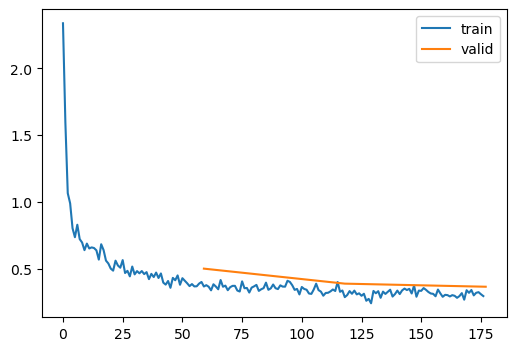

In [63]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

# Towards 90%...

In [64]:
dls = DataLoaders.from_dd(tds, 256)

accuracy,loss,epoch,train
0.836,0.449,0,train
0.862,0.382,0,eval
0.880,0.322,1,train
0.874,0.350,1,eval
0.892,0.292,2,train
0.861,0.391,2,eval


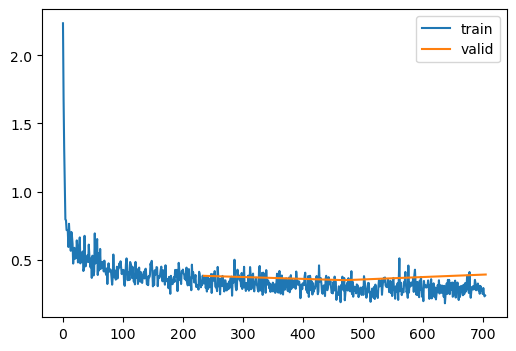

In [65]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.912,0.238,0,train
0.896,0.285,0,eval
0.918,0.224,1,train
0.896,0.285,1,eval


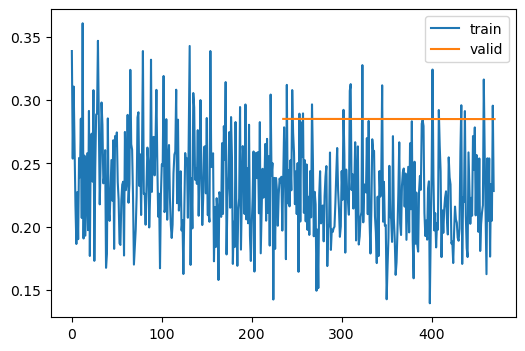

In [66]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

# Export

In [67]:
import nbdev; nbdev.nbdev_export()